# Cleaning US Census Data

In this project, I demonstrate techniques used to clean messy data, using US Census data as an example.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

## Combine Multiple CSV Files into One DataFrame

We use glob to combine multiple csv files into a single DataFrame.

In [2]:
# Use glob to open multiple csvs and concat them into one df
files= glob.glob("states*.csv")
df_list= []
for filename in files:
  data= pd.read_csv(filename)
  df_list.append(data)
us_census= pd.concat(df_list)

## Inspect Columns and Datatypes

Next, we inspect the columns and datatypes of our new DataFrame.

In [3]:
print(us_census.columns)

Index(['Unnamed: 0', 'State', 'TotalPop', 'Hispanic', 'White', 'Black',
       'Native', 'Asian', 'Pacific', 'Income', 'GenderPop'],
      dtype='object')


In [4]:
print(us_census.dtypes)

Unnamed: 0     int64
State         object
TotalPop       int64
Hispanic      object
White         object
Black         object
Native        object
Asian         object
Pacific       object
Income        object
GenderPop     object
dtype: object


It looks like some object dtypes will be easier to work with as floats or ints. Let's inspect the head.

In [5]:
print(us_census.head())

   Unnamed: 0       State  TotalPop Hispanic   White   Black  Native   Asian  \
0           0     Alabama   4830620    3.75%  61.88%  31.25%   0.45%   1.05%   
1           1      Alaska    733375    5.91%  60.91%   2.85%  16.39%   5.45%   
2           2     Arizona   6641928   29.57%  57.12%   3.85%   4.36%   2.88%   
3           3    Arkansas   2958208    6.22%  71.14%  18.97%   0.52%   1.14%   
4           4  California  38421464   37.29%  40.22%   5.68%   0.41%  13.05%   

  Pacific       Income            GenderPop  
0   0.03%  $43,296.36     2341093M_2489527F  
1   1.06%  $70,354.74       384160M_349215F  
2   0.17%  $54,207.82     3299088M_3342840F  
3   0.15%  $41,935.63     1451913M_1506295F  
4   0.35%  $67,264.78   19087135M_19334329F  


After inspecting the head, we can see that a lot of columns contain numerical data, but the data has been stored in string form. We will have to convert a lot of this to floats.

In [6]:
# drop duplicates
us_census= us_census.drop_duplicates(subset=['State'])

## Convert an Object to a Numeric Datatype

First, let's convert the Income column to a float value using regular expressions. We begin by replacing the '$' character with an empty string.

In [7]:
us_census.Income= us_census['Income'].replace('[\$,]', '', regex=True)

Next, we convert the data from dtype object to dtype float.

In [8]:
us_census.Income= pd.to_numeric(us_census.Income)

## Split a Column

In order to make the GenderPop column easier to work with, we will separate it into two new columns, Men and Women, with the population values stored as ints.

In [9]:
# use a dummy DataFrame to store the split columns
split_df= us_census['GenderPop'].str.split('_', expand=True)

# remove 'M' and 'F' from the split columns
split_df[0]= split_df[0].replace('[M,]', '', regex=True)
split_df[1]= split_df[1].replace('[F,]', '', regex=True)

# convert values to numerics
split_df[0]= pd.to_numeric(split_df[0])
split_df[1]= pd.to_numeric(split_df[1])

We can see that the values for the female population are floats, but the male population is denoted in ints. This is due to the fact that some rows only report the male population and the total population, and do not explicitly list the value for the female population. We will address this after we append our new columns to the original DataFrame.

In [10]:
us_census['Men']= split_df[0]
us_census['Women']= split_df[1]

Now that our DataFrame has columns for the male and female populations, let's fix the NaN values in the Women column.

In [11]:
us_census= us_census.fillna(value={
    'Women': us_census['TotalPop'] - us_census['Men']
})

# convert Women values to ints
us_census['Women']= us_census['Women'].astype('int64')

## Make a Scatterplot (Average Income by Population of Women)

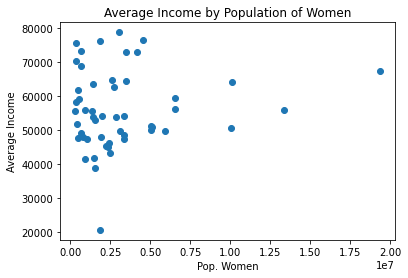

<Figure size 432x288 with 0 Axes>

In [12]:
plt.scatter(us_census['Women'], us_census['Income'])
plt.xlabel('Pop. Women')
plt.ylabel('Average Income')
plt.title('Average Income by Population of Women')
plt.show()
plt.clf()

## Make Histograms for Race Data

In order to make histograms for the race data, we need to clean the data by removing the percentage character and converting the data into a numeric format.

In [13]:
print(us_census[['State','Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific']].head())

        State Hispanic   White   Black  Native   Asian Pacific
0     Alabama    3.75%  61.88%  31.25%   0.45%   1.05%   0.03%
1      Alaska    5.91%  60.91%   2.85%  16.39%   5.45%   1.06%
2     Arizona   29.57%  57.12%   3.85%   4.36%   2.88%   0.17%
3    Arkansas    6.22%  71.14%  18.97%   0.52%   1.14%   0.15%
4  California   37.29%  40.22%   5.68%   0.41%  13.05%   0.35%


In [14]:
# fill nan's for Pacific group with 0.00%
us_census= us_census.fillna(value={
    "Pacific": '0.00%'
})

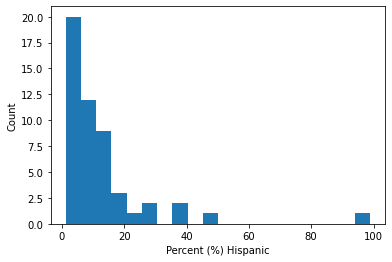

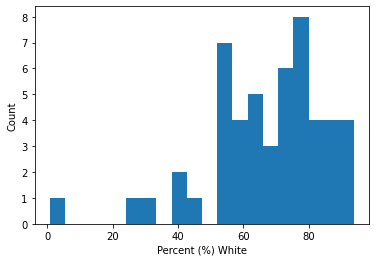

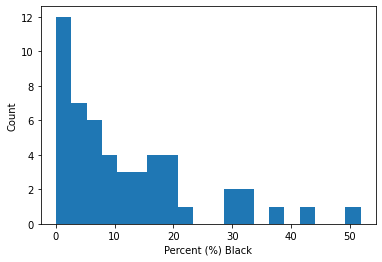

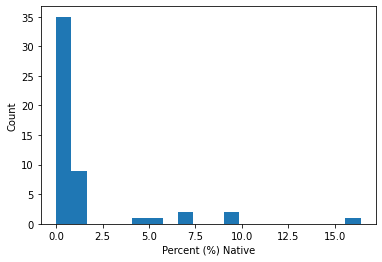

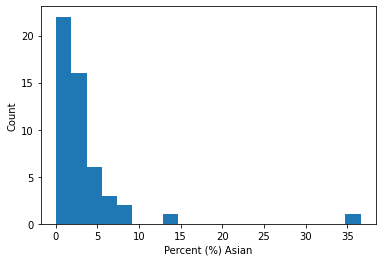

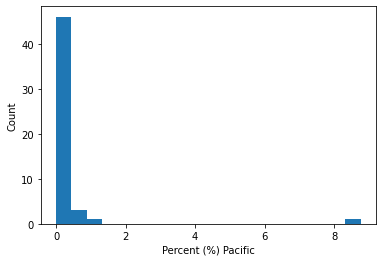

<Figure size 432x288 with 0 Axes>

In [30]:
# remove % character
races= ['Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific']

for race in races:
    us_census[race]= us_census[race].replace('[%,]', '', regex=True)
    us_census[race]= pd.to_numeric(us_census[race])
    plt.hist(us_census[race], bins=20)
    plt.xlabel('Percent (%) {}'.format(race))
    plt.ylabel('Count')
    plt.show()
    plt.clf()